# Import Libraries

In [1]:
import pandas as pd
import geopandas as gpd
import fiona
import geopandas.geoseries  
import folium
import plotly.express as px
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import contextily as ctx
from shapely import wkt
import esda
from esda.moran import Moran, Moran_Local
import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation
import libpysal as lps

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


In [2]:
def nhdissolve(df,geometry,math,skip=False):
    
    #Import neighborhood shapes
    url = "https://usc.data.socrata.com/api/geospatial/r8qd-yxsr?method=export&format=GeoJSON"
    nhoods=gpd.read_file(url)
   
    #This is to make the geography column recognizable, toggling skip to True allows you to avoid an error message if your geometry column does not need this operation
    runwkts=skip
    if runwkts==False:
        df[geometry] = df[geometry].apply(wkt.loads)
    #add a CRS
    gdf = gpd.GeoDataFrame(df, crs="EPSG:4326",geometry='geometry')
     #join race with nh shapes, rename neighborhood column, and set it as the index
    nhjoin=gdf.overlay(nhoods, how='intersection')
    nhjoin=nhjoin.rename(columns={'name':'Neighborhood'})
    nhjoin.set_index('Neighborhood',inplace=True)
    
    #drop shapes not in city of LA
    nhjoin.drop(nhjoin[nhjoin['type'] != 'segment-of-a-city'].index, inplace = True)

    #approximate average for data in neighborhoods 
    nhdata= nhjoin.dissolve(by='Neighborhood', aggfunc= math)
    nhdata.head()
    return nhdata
    

## Once you've run the function with your dataframe:
You can call for your new variable in a map 

In the example above this would be 'test'

I'll run an example below:

In [3]:
# step 1- import your data (needs to have a geometry column) 
testdf=pd.read_csv('data/racetracts.csv')

In [4]:
# Step 2- plug it into the function 
example= nhdissolve(df=testdf,geometry='geometry',math='sum')

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1676: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated_data = data.groupby(**groupby_kwargs).agg(aggfunc)


In [5]:
# Import housing and jobs by neighborhood data 
jh=pd.read_csv('data/jh.csv')
jh['geometry'] = jh['geometry'].apply(wkt.loads)
    #add a CRS
jhgdf = gpd.GeoDataFrame(jh, crs="EPSG:4326",geometry='geometry')

jhgdf=jhgdf.drop(columns=['Unnamed: 0.1','Unnamed: 0','OBJECTID','year_x','year_y','square_miles','description','source_link'])
jhgdf.head()

,CITY,Neighborhood,Units of Housing,Number of Jobs,set,slug,region,type,Number of Jobs Per Unit of Housing,geometry,Jobs to Housing Quantiles
0,IN,Pico-Union,13618.70,10516.11,L.A. County Neighborhoods (Current),pico-union,Central L.A.,segment-of-a-city,0.772182,"POLYGON ((-118.29271 34.05291, -118.29161 34.0...",2
1,IN,Sylmar,22156.30,20444.10,L.A. County Neighborhoods (Current),sylmar,San Fernando Valley,segment-of-a-city,0.922722,"POLYGON ((-118.41998 34.32917, -118.41998 34.3...",3
2,IN,North Hills,17637.30,9615.66,L.A. County Neighborhoods (Current),north-hills,San Fernando Valley,segment-of-a-city,0.545189,"POLYGON ((-118.47202 34.25720, -118.47203 34.2...",1
3,IN,Harbor Gateway,13329.57,31028.04,L.A. County Neighborhoods (Current),harbor-gateway,Harbor,segment-of-a-city,2.327760,"POLYGON ((-118.28141 33.92320, -118.28146 33.9...",4
4,IN,Lake Balboa,9621.27,10142.76,L.A. County Neighborhoods (Current),lake-balboa,San Fernando Valley,segment-of-a-city,1.054202,"POLYGON ((-118.50102 34.21540, -118.50092 34.2...",3


In [6]:
# spatial join 
ms = jhgdf.sjoin(example, how="left")
ms.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 628 entries, 0 to 109
Data columns (total 25 columns):
 #   Column                                                   Non-Null Count  Dtype   
---  ------                                                   --------------  -----   
 0   CITY                                                     628 non-null    object  
 1   Neighborhood                                             628 non-null    object  
 2   Units of Housing                                         628 non-null    float64 
 3   Number of Jobs                                           628 non-null    float64 
 4   set                                                      628 non-null    object  
 5   slug                                                     628 non-null    object  
 6   region                                                   628 non-null    object  
 7   type                                                     628 non-null    object  
 8   Number of Jo

In [7]:
# calculate spatial weight
wq =  lps.weights.KNN.from_dataframe(jhgdf,k=8)

# Row-standardization
wq.transform = 'r'

### Spatial lag

Now that we have our spatial weights assigned, we use it to calculate the spatial lag. While the mathematical operations are beyond the scope of this lab, you are welcome to check it out [here](https://geographicdata.science/book/notebooks/06_spatial_autocorrelation.html#spatial-lag). Simply put, the spatial lag is a calculated assignment to each geography in your data, which takes into account the data values from others in their  "neighborhood" as defined by the spatial weight. This operation can be done with a single line of code which is part of the pysal module, but the underlying calculations are not that difficult to understand: 

It takes the average of all the neighbors as defined by the spatial weight to come up with a single associated value.

In [8]:
# create a new column for the spatial lag
jhgdf['Number_jobs_div_Housing_Lag'] = lps.weights.lag_spatial(wq, jhgdf['Number of Jobs Per Unit of Housing'])

In [9]:
# take a look at some sample rows
jhgdf.sample(10)[['Neighborhood','Number_jobs_div_Housing_Lag']]

,Neighborhood,Number_jobs_div_Housing_Lag
67,Broadway-Manchester,0.319020
80,Tarzana,1.127920
91,West Los Angeles,3.324246
35,Wilmington,0.636582
88,Century City,1.681483
8,Toluca Lake,1.163885
38,Encino,0.934558
49,Elysian Valley,1.026170
26,Silver Lake,1.014356
109,Gramercy Park,0.330916


<div class="alert alert-info">
Take a moment to look at the values in the dataframe. What do they tell you?
</div>

### The donut and the diamond

In [10]:
# create a column that calculates the difference between arrests and lag
jhgdf['JH_lag_diff'] = jhgdf['Number of Jobs Per Unit of Housing'] - jhgdf['Number_jobs_div_Housing_Lag']

In [11]:
# output to get the head and tail
jhgdf.sort_values(by='JH_lag_diff')

,CITY,Neighborhood,Units of Housing,Number of Jobs,set,slug,region,type,Number of Jobs Per Unit of Housing,geometry,Jobs to Housing Quantiles,Number_jobs_div_Housing_Lag,JH_lag_diff
57,IN,Beverly Crest,5183.79,1866.06,L.A. County Neighborhoods (Current),beverly-crest,Westside,segment-of-a-city,0.359980,"POLYGON ((-118.39484 34.11242, -118.39498 34.1...",0,3.726147,-3.366167
31,IN,Cheviot Hills,3564.48,1749.25,L.A. County Neighborhoods (Current),cheviot-hills,Westside,segment-of-a-city,0.490745,"POLYGON ((-118.40121 34.02941, -118.40591 34.0...",1,3.797581,-3.306836
104,IN,Bel-Air,3265.79,3195.01,L.A. County Neighborhoods (Current),bel-air,Westside,segment-of-a-city,0.978327,"POLYGON ((-118.46742 34.12921, -118.46641 34.1...",3,3.908144,-2.929817
66,IN,Pico-Robertson,8543.77,5339.96,L.A. County Neighborhoods (Current),pico-robertson,Westside,segment-of-a-city,0.625012,"POLYGON ((-118.40590 34.05369, -118.40595 34.0...",2,3.385802,-2.760790
54,IN,Beverlywood,2843.32,2141.86,L.A. County Neighborhoods (Current),beverlywood,Westside,segment-of-a-city,0.753295,"POLYGON ((-118.38951 34.04951, -118.38541 34.0...",2,3.463390,-2.710095
...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,IN,Carthay,2766.49,7745.71,L.A. County Neighborhoods (Current),carthay,Central L.A.,segment-of-a-city,2.799833,"POLYGON ((-118.36151 34.06301, -118.36381 34.0...",4,1.318052,1.481781
3,IN,Harbor Gateway,13329.57,31028.04,L.A. County Neighborhoods (Current),harbor-gateway,Harbor,segment-of-a-city,2.327760,"POLYGON ((-118.28141 33.92320, -118.28146 33.9...",4,0.438078,1.889682
82,IN,Westchester,17434.97,80734.38,L.A. County Neighborhoods (Current),westchester,South Bay,segment-of-a-city,4.630600,"POLYGON ((-118.35855 33.98167, -118.35867 33.9...",4,0.918725,3.711875
37,IN,Downtown,36154.32,335257.20,L.A. County Neighborhoods (Current),downtown,Central L.A.,segment-of-a-city,9.272950,"POLYGON ((-118.22323 34.01495, -118.22339 34.0...",4,1.345876,7.927074


## Spatial lag map


/opt/conda/lib/python3.10/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 28 is not valid for the current tile provider (valid zooms: 0 - 20).
  warnings.warn(msg)


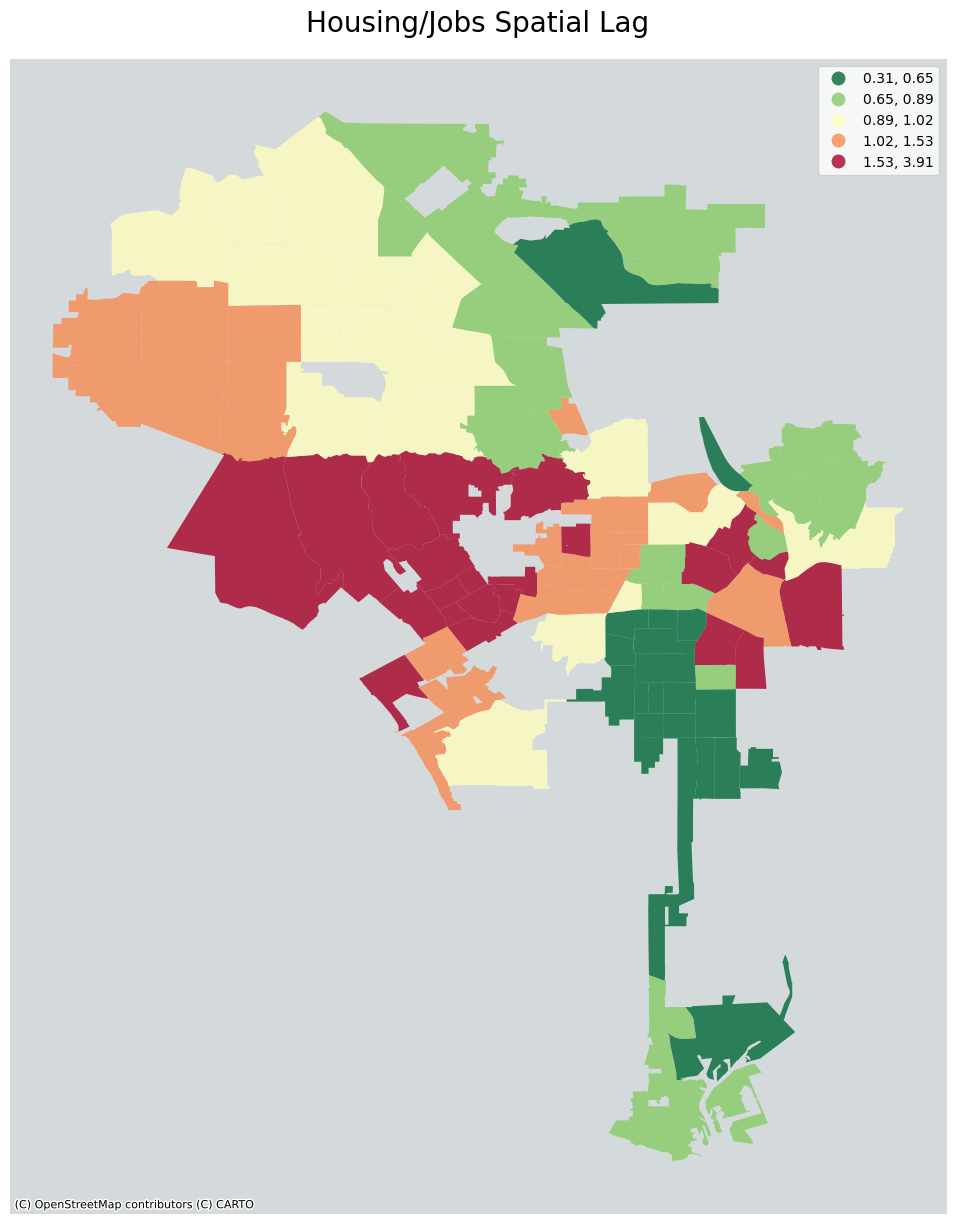

In [12]:
# use subplots that make it easier to create multiple layered maps
fig, ax = plt.subplots(figsize=(15, 15))

# spatial lag choropleth
jhgdf.plot(ax=ax,
         figsize=(15,15),
         column='Number_jobs_div_Housing_Lag',
         legend=True,
         alpha=0.8,
         cmap='RdYlGn_r',
         scheme='quantiles')

ax.axis('off')
ax.set_title('Housing/Jobs Spatial Lag',fontsize=20,pad=20)

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

## Moran's Plot

We now have a spatial lag map: a map that displays geographies weighted against the values of its neighbors. The clusters are much clearer and cleaner than the original arrest count map. Downtown, Venice, South LA, Van Nuys... But we still have not *quantified* the degree of the spatial correlations. To begin this process, we test for global autocorrelation for a continuous attribute (arrest counts).

In [13]:
jhgdf.set_index
y = jhgdf['Number_jobs_div_Housing_Lag']
moran = Moran(y, wq)
moran.I

0.6996363723684298

The moran's I value is nothing more than the calculated slope of the scatterplot of our "arrests per 1000" and "arrests per 1000 spatial lag" columns. It does indicate whether or not you have a positive or negative autocorrelation. Values will range from positive one, to negative one. 

- **Positive** spatial autocorrelation: high values are close to high values, and/or low values are close to low values
- **Negative** spatial autocorrelation (less common): similar values are far from each other; high values are next to low values, low values are next to high values

You can output a scatterplot:

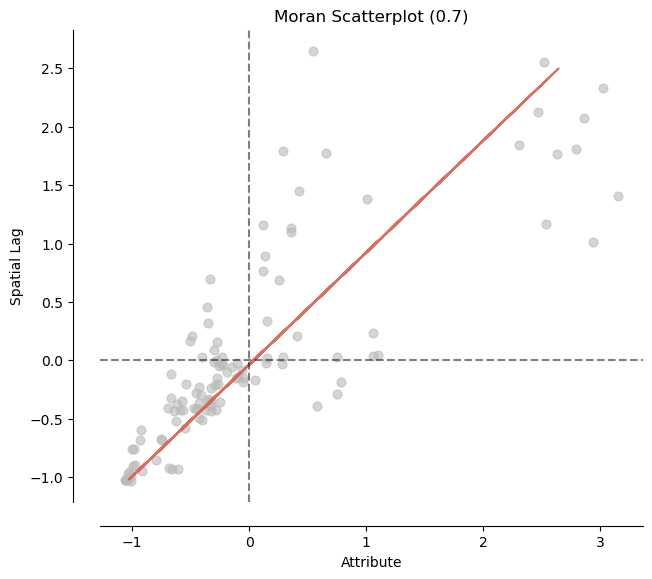

In [14]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

In [15]:
moran.p_sim

0.001

In [16]:
jhgdf.set_index
y = jhgdf['Number_jobs_div_Housing_Lag']
moran = Moran(y, wq)
moran.I

0.6996363723684298

The moran's I value is nothing more than the calculated slope of the scatterplot of our "arrests per 1000" and "arrests per 1000 spatial lag" columns. It does indicate whether or not you have a positive or negative autocorrelation. Values will range from positive one, to negative one. 

- **Positive** spatial autocorrelation: high values are close to high values, and/or low values are close to low values
- **Negative** spatial autocorrelation (less common): similar values are far from each other; high values are next to low values, low values are next to high values

You can output a scatterplot:

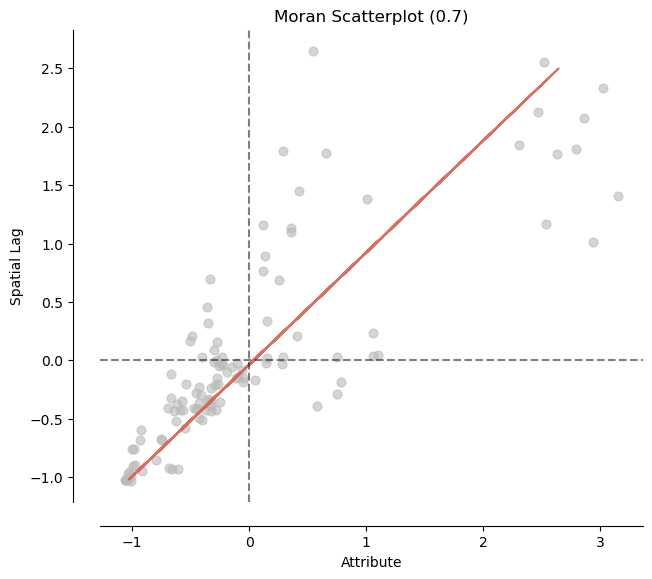

In [17]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

In [18]:
moran.p_sim

0.001

## Moran Local Scatterplot

In [19]:
# calculate local moran values
lisa = esda.moran.Moran_Local(y, wq)

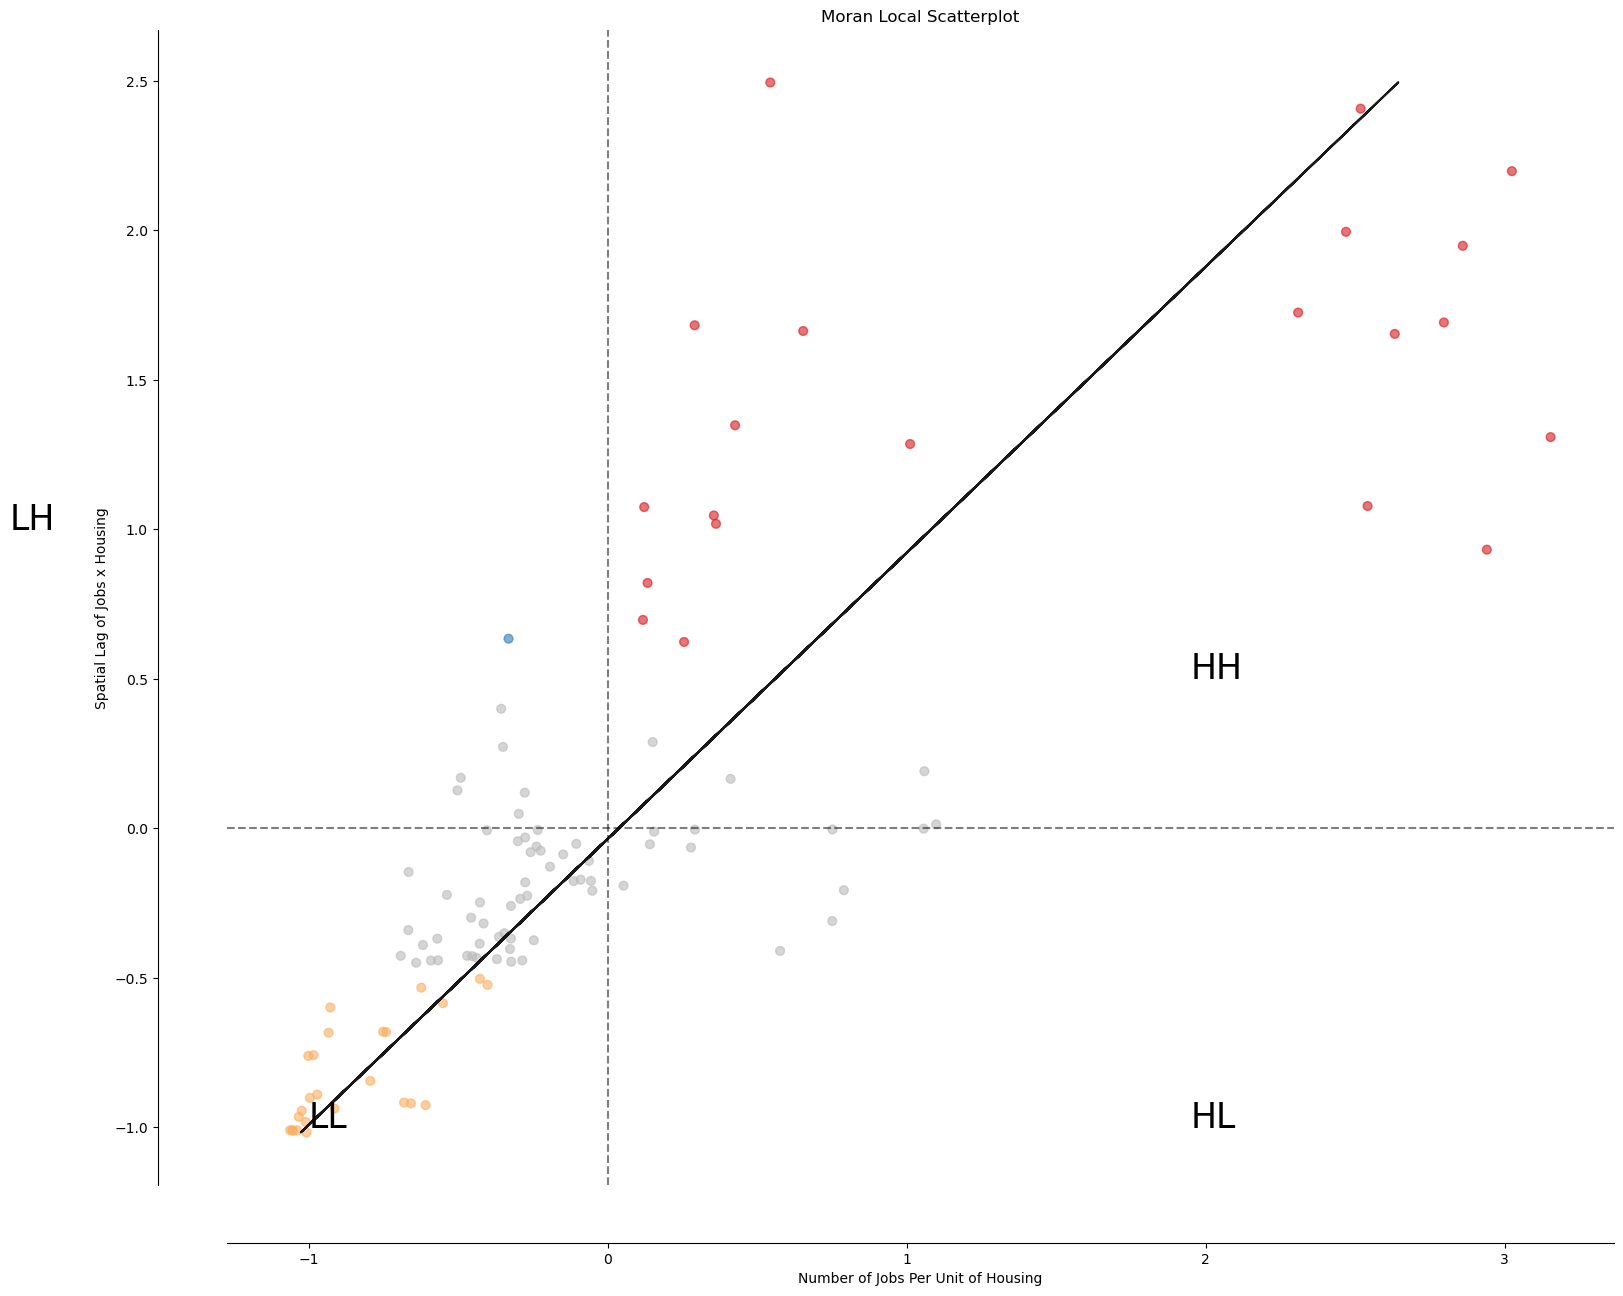

In [20]:
# Plot
fig,ax = plt.subplots(figsize=(20,15))

moran_scatterplot(lisa, ax=ax, p=0.05)
ax.set_xlabel("Number of Jobs Per Unit of Housing")
ax.set_ylabel('Spatial Lag of Jobs x Housing')

# add some labels
plt.text(1.95, 0.5, "HH", fontsize=25)
plt.text(1.95, -1, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()

In the scatterplot above, the colored dots represents the rows (census block groups) that have a P-value less that 0.05 in each quadrant. In other words, these are the statisticaly significantly, spatially autocorrelated geographies.

## Spatial Autocorrelation Map
Finally, you can visually these statistically significant clusters using the `lisa_cluster` function:

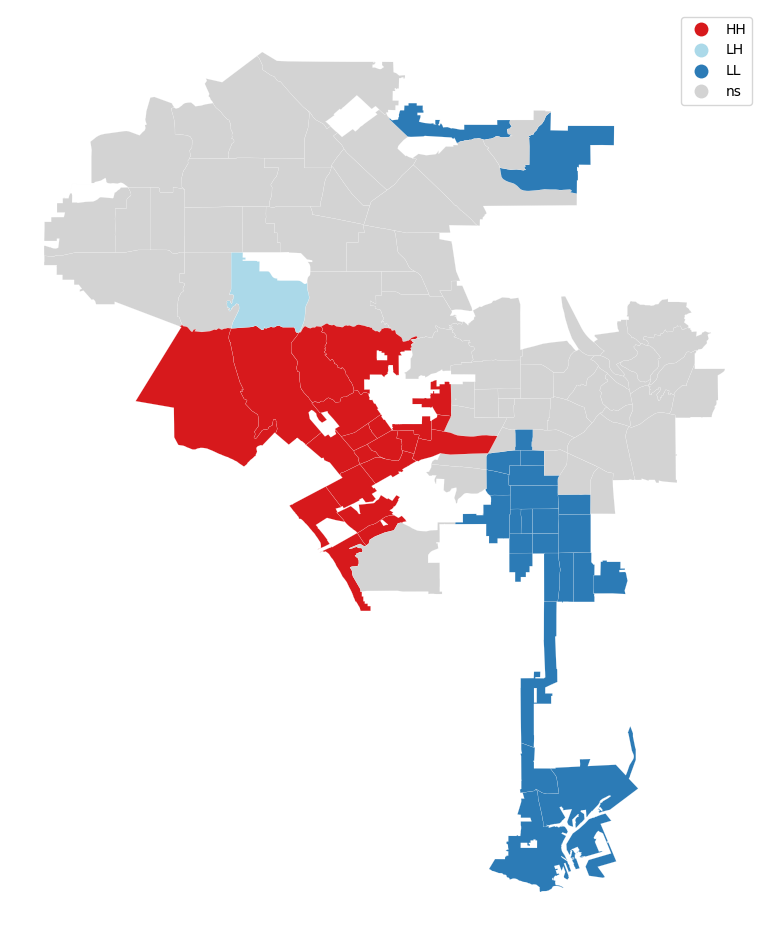

In [21]:
fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(lisa, jhgdf, p=0.05, ax=ax)
plt.show()

And create a map comparing different p-values

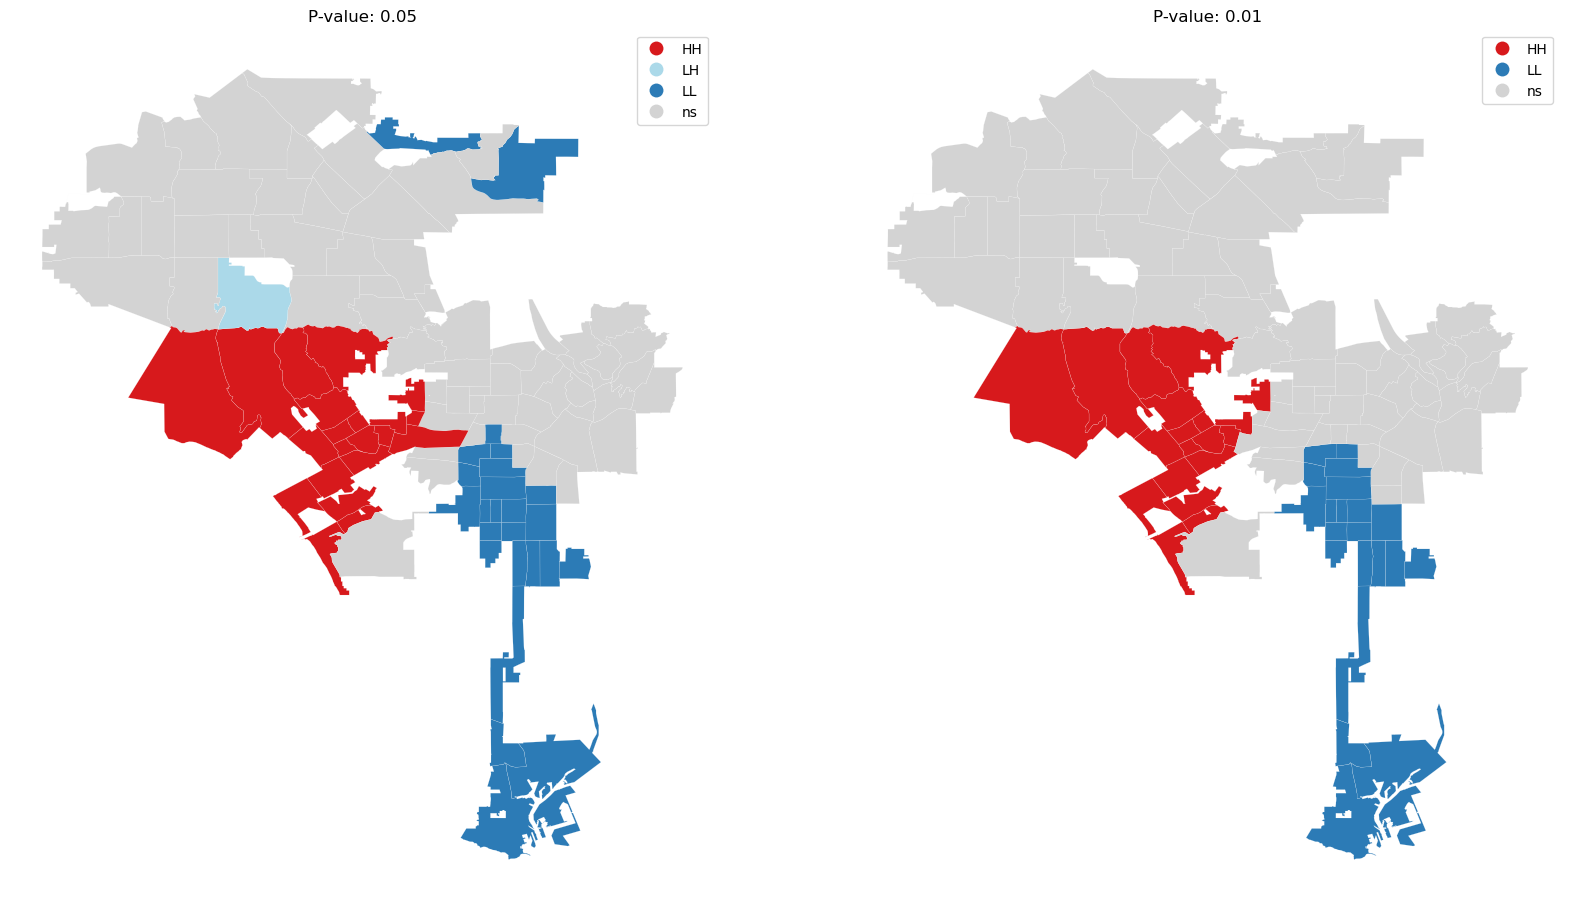

In [22]:
# create the 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 12))

# regular count map on the left
lisa_cluster(lisa, jhgdf, p=0.05, ax=ax[0])

ax[0].axis("off")
ax[0].set_title("P-value: 0.05")

# spatial lag map on the right
lisa_cluster(lisa, jhgdf, p=0.01, ax=ax[1])
ax[1].axis("off")
ax[1].set_title("P-value: 0.01")

plt.show()

# Doing all years 

In [23]:
#import jobs 

j2011=pd.read_csv('data/Total Jobs - 2011.csv')
j2012=pd.read_csv('data/Total Jobs - 2012.csv')
j2013=pd.read_csv('data/Total Jobs - 2013.csv')
j2014=pd.read_csv('data/Total Jobs - 2014.csv')
j2015=pd.read_csv('data/Total Jobs - 2015.csv')
j2016=pd.read_csv('data/Total Jobs - 2016.csv')
j2017=pd.read_csv('data/Total Jobs - 2017.csv')
j2018=pd.read_csv('data/Total Jobs - 2018.csv')

dflist=[j2011,j2012,j2013,j2014,j2015,j2016,j2017,j2018]

for jobs in dflist:
    jobs=jobs.rename(columns={'name':'Neighborhood'},inplace=True)
    
j2018.head()

,Neighborhood,year,total_jobs_count
0,Irwindale,2018,17491.31
1,Pico-Union,2018,11117.75
2,Glendora,2018,20474.53
3,Industry,2018,60652.75
4,Sylmar,2018,21064.35


In [24]:
h=pd.read_csv('data/All Years Total Housing Units Calculations.csv')
h.head()

,geoid,geoid20,year,housing_units_count
0,1400000US06037101110,6037101110,2021,1639.0
1,1400000US06037101122,6037101122,2021,1426.0
2,1400000US06037101220,6037101220,2021,1399.0
3,1400000US06037101221,6037101221,2021,1556.0
4,1400000US06037101222,6037101222,2021,994.0


In [25]:
def prepend(list, str):
 
    # Using format()
    str += '{0}'
    list = [str.format(i) for i in list]
    return(list)


In [26]:
yearlist=[2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
hlist=['h2011',
 'h2012',
 'h2013',
 'h2014',
 'h2015',
 'h2016',
 'h2017',
 'h2018',
 'h2019']
    

In [27]:
def dfgen(year):
            df=h[h['year'] == year] 
            return df
        

In [28]:
tracts = gpd.read_file('data/Census_Tracts_2020.geojson')
tracts['geoid']='1400000US06037'+tracts['CT20']
tracts.head()

,OBJECTID,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry,geoid
0,1,101110,1011.10,1.229562e+07,15083.854287,"POLYGON ((-118.28491 34.25948, -118.28492 34.2...",1400000US06037101110
1,2,101122,1011.22,2.845774e+07,31671.455844,"POLYGON ((-118.29015 34.27417, -118.29015 34.2...",1400000US06037101122
2,3,101220,1012.20,7.522093e+06,12698.783810,"POLYGON ((-118.28100 34.25592, -118.28198 34.2...",1400000US06037101220
3,4,101221,1012.21,3.812000e+06,9161.710543,"POLYGON ((-118.28735 34.25591, -118.28863 34.2...",1400000US06037101221
4,5,101222,1012.22,3.191371e+06,9980.600461,"POLYGON ((-118.28594 34.25405, -118.28594 34.2...",1400000US06037101222


In [29]:
h=h.merge(tracts,how='left',on='geoid')
h.head()

,geoid,geoid20,year,housing_units_count,OBJECTID,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry
0,1400000US06037101110,6037101110,2021,1639.0,1.0,101110,1011.10,1.229562e+07,15083.854287,"POLYGON ((-118.28491 34.25948, -118.28492 34.2..."
1,1400000US06037101122,6037101122,2021,1426.0,2.0,101122,1011.22,2.845774e+07,31671.455844,"POLYGON ((-118.29015 34.27417, -118.29015 34.2..."
2,1400000US06037101220,6037101220,2021,1399.0,3.0,101220,1012.20,7.522093e+06,12698.783810,"POLYGON ((-118.28100 34.25592, -118.28198 34.2..."
3,1400000US06037101221,6037101221,2021,1556.0,4.0,101221,1012.21,3.812000e+06,9161.710543,"POLYGON ((-118.28735 34.25591, -118.28863 34.2..."
4,1400000US06037101222,6037101222,2021,994.0,5.0,101222,1012.22,3.191371e+06,9980.600461,"POLYGON ((-118.28594 34.25405, -118.28594 34.2..."


In [30]:
hlist=['h2011',
 'h2012',
 'h2013',
 'h2014',
 'h2015',
 'h2016',
 'h2017',
 'h2018',
 'h2019']

In [31]:
h2011=dfgen(year=2011)
h2012=dfgen(year=2012)
h2013=dfgen(year=2013)
h2014=dfgen(year=2014)
h2015=dfgen(year=2015)
h2016=dfgen(year=2016)
h2017=dfgen(year=2017)
h2018=dfgen(year=2018)
h2019=dfgen(year=2019)

In [32]:
h2012.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2494 entries, 22454 to 24947
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   geoid                2494 non-null   object  
 1   geoid20              2494 non-null   int64   
 2   year                 2494 non-null   int64   
 3   housing_units_count  2475 non-null   float64 
 4   OBJECTID             2494 non-null   float64 
 5   CT20                 2494 non-null   object  
 6   LABEL                2494 non-null   object  
 7   ShapeSTArea          2494 non-null   float64 
 8   ShapeSTLength        2494 non-null   float64 
 9   geometry             2494 non-null   geometry
dtypes: float64(4), geometry(1), int64(2), object(3)
memory usage: 214.3+ KB


In [33]:
def nhdissolve(df,geometry,math,skip=False):
    
    #Import neighborhood shapes
    url = "https://usc.data.socrata.com/api/geospatial/r8qd-yxsr?method=export&format=GeoJSON"
    nhoods=gpd.read_file(url)
   
    #This is to make the geography column recognizable, toggling skip to True allows you to avoid an error message if your geometry column does not need this operation
    runwkts=skip
    if runwkts==False:
        df[geometry] = df[geometry].apply(wkt.loads)
    #add a CRS
    gdf = gpd.GeoDataFrame(df, crs="EPSG:4326",geometry='geometry')
     #join race with nh shapes, rename neighborhood column, and set it as the index
    nhjoin=gdf.overlay(nhoods, how='intersection')
    nhjoin=nhjoin.rename(columns={'name':'Neighborhood'})
    
    
    #drop shapes not in city of LA
    nhjoin.drop(nhjoin[nhjoin['type'] != 'segment-of-a-city'].index, inplace = True)

    #approximate average for data in neighborhoods 
    nhdata= nhjoin.dissolve(by='Neighborhood', aggfunc= math)
    nhdata.reset_index(inplace=True)
    return nhdata

In [34]:
h2011=nhdissolve(h2011,geometry='geometry_x',math='sum',skip=True)


/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1676: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated_data = data.groupby(**groupby_kwargs).agg(aggfunc)


In [35]:
h2012=nhdissolve(h2012,geometry='geometry_x',math='sum',skip=True)


/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1676: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated_data = data.groupby(**groupby_kwargs).agg(aggfunc)


In [36]:
h2013=nhdissolve(h2013,geometry='geometry_x',math='sum',skip=True)

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1676: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated_data = data.groupby(**groupby_kwargs).agg(aggfunc)


In [37]:
h2014=nhdissolve(h2014,geometry='geometry_x',math='sum',skip=True)

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1676: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated_data = data.groupby(**groupby_kwargs).agg(aggfunc)


In [38]:
h2015=nhdissolve(h2015,geometry='geometry_x',math='sum',skip=True)

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1676: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated_data = data.groupby(**groupby_kwargs).agg(aggfunc)


In [39]:
h2016=nhdissolve(h2016,geometry='geometry_x',math='sum',skip=True)

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1676: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated_data = data.groupby(**groupby_kwargs).agg(aggfunc)


In [40]:
h2017=nhdissolve(h2017,geometry='geometry_x',math='sum',skip=True)

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1676: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated_data = data.groupby(**groupby_kwargs).agg(aggfunc)


In [41]:
h2018=nhdissolve(h2018,geometry='geometry_x',math='sum',skip=True)

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1676: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated_data = data.groupby(**groupby_kwargs).agg(aggfunc)


In [42]:
h2019=nhdissolve(h2019,geometry='geometry_x',math='sum',skip=True)
h2019.head()

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1676: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated_data = data.groupby(**groupby_kwargs).agg(aggfunc)


,Neighborhood,geometry,geoid20,year,housing_units_count,OBJECTID,ShapeSTArea,ShapeSTLength
0,Adams-Normandie,"POLYGON ((-118.30541 34.02571, -118.30890 34.0...",66409439227,22209,12215.0,8278.0,5.194088e+07,107582.924663
1,Arleta,"POLYGON ((-118.43579 34.22987, -118.43582 34.2...",84519667245,28266,15122.0,2078.0,1.977866e+08,226887.739091
2,Arlington Heights,"POLYGON ((-118.33381 34.03501, -118.33271 34.0...",78483820162,26247,16577.0,9240.0,7.472264e+07,137728.457729
3,Atwater Village,"POLYGON ((-118.27051 34.12151, -118.27331 34.1...",72447729825,24228,19436.0,11452.0,3.720516e+08,286349.733482
4,Baldwin Hills/Crenshaw,"POLYGON ((-118.36504 34.00556, -118.36623 34.0...",126784467665,42399,36029.0,24429.0,2.715788e+08,350832.124002


In [43]:

jh2011=h2011.merge(j2011,how='left',on='Neighborhood')
jh2012=h2012.merge(j2012,how='left',on='Neighborhood')
jh2013=h2013.merge(j2013,how='left',on='Neighborhood')
jh2014=h2014.merge(j2014,how='left',on='Neighborhood')
jh2015=h2015.merge(j2015,how='left',on='Neighborhood')
jh2016=h2012.merge(j2016,how='left',on='Neighborhood')
jh2017=h2017.merge(j2017,how='left',on='Neighborhood')
jh2018=h2018.merge(j2018,how='left',on='Neighborhood')
jh2018.head()

,Neighborhood,geometry,geoid20,year_x,housing_units_count,OBJECTID,ShapeSTArea,ShapeSTLength,year_y,total_jobs_count
0,Adams-Normandie,"POLYGON ((-118.30541 34.02571, -118.30890 34.0...",66409439227,22198,12052.0,8278.0,5.194088e+07,107582.924663,2018.0,1754.53
1,Arleta,"POLYGON ((-118.43579 34.22987, -118.43582 34.2...",84519667245,28252,14960.0,2078.0,1.977866e+08,226887.739091,2018.0,2900.77
2,Arlington Heights,"POLYGON ((-118.33381 34.03501, -118.33271 34.0...",78483820162,26234,16438.0,9240.0,7.472264e+07,137728.457729,2018.0,3044.11
3,Atwater Village,"POLYGON ((-118.27051 34.12151, -118.27331 34.1...",72447729825,24216,19087.0,11452.0,3.720516e+08,286349.733482,2018.0,7155.88
4,Baldwin Hills/Crenshaw,"POLYGON ((-118.36504 34.00556, -118.36623 34.0...",126784467665,42378,35583.0,24429.0,2.715788e+08,350832.124002,2018.0,7290.35


In [44]:
jhlist=[jh2011,
jh2012,
jh2013,
jh2014,
jh2015,
jh2016,
jh2017,
jh2018]

for jh in jhlist:
    jh=jh.drop(columns={'year_x'},inplace=True)
for jh in jhlist:
    jh=jh.rename(columns={'year_y':'Year'},inplace=True)  
for jh in jhlist:
    jh['Year'] =  jh.Year.astype(str)
    


In [45]:


for jh in jhlist:
    jh['Year'] = jh['Year'].map(lambda x: x.rstrip('.0'))

for jh in jhlist:
    jh = gpd.GeoDataFrame(jh, crs="EPSG:4326",geometry='geometry')



In [46]:
for jh in jhlist:
    jh['jobsperunithousing'] = jh['total_jobs_count']/jh['housing_units_count']

In [47]:
jh2018.head()

,Neighborhood,geometry,geoid20,housing_units_count,OBJECTID,ShapeSTArea,ShapeSTLength,Year,total_jobs_count,jobsperunithousing
0,Adams-Normandie,"POLYGON ((-118.30541 34.02571, -118.30890 34.0...",66409439227,12052.0,8278.0,5.194088e+07,107582.924663,2018,1754.53,0.145580
1,Arleta,"POLYGON ((-118.43579 34.22987, -118.43582 34.2...",84519667245,14960.0,2078.0,1.977866e+08,226887.739091,2018,2900.77,0.193902
2,Arlington Heights,"POLYGON ((-118.33381 34.03501, -118.33271 34.0...",78483820162,16438.0,9240.0,7.472264e+07,137728.457729,2018,3044.11,0.185187
3,Atwater Village,"POLYGON ((-118.27051 34.12151, -118.27331 34.1...",72447729825,19087.0,11452.0,3.720516e+08,286349.733482,2018,7155.88,0.374909
4,Baldwin Hills/Crenshaw,"POLYGON ((-118.36504 34.00556, -118.36623 34.0...",126784467665,35583.0,24429.0,2.715788e+08,350832.124002,2018,7290.35,0.204883


In [54]:
def autocorrelate(jh):
# calculate spatial weight
    wq =  lps.weights.KNN.from_dataframe(jh,k=8)

    # Row-standardization
    wq.transform = 'r'

    # create a new column for the spatial lag
    jh['Number_jobs_div_Housing_Lag'] = lps.weights.lag_spatial(wq, jh['jobsperunithousing'])

    # create a column that calculates the difference between arrests and lag
    jh['JH_lag_diff'] = jh['jobsperunithousing'] - jh['Number_jobs_div_Housing_Lag']
  
    # output to get the head and tail
    jh.sort_values(by='JH_lag_diff')
    
    return jh.sort_values(by='JH_lag_diff')
    
  

In [55]:
output=autocorrelate(jh2014)

In [56]:
output

,Neighborhood,geometry,geoid20,housing_units_count,OBJECTID,ShapeSTArea,ShapeSTLength,Year,total_jobs_count,jobsperunithousing,Number_jobs_div_Housing_Lag,JH_lag_diff
26,Echo Park,"POLYGON ((-118.25951 34.06191, -118.25991 34.0...",108670359083,24250.0,11608.0,1.550145e+08,2.426939e+05,2014,7317.41,0.301749,1.383854,-1.082105
5,Bel-Air,"POLYGON ((-118.45899 34.07444, -118.45914 34.0...",60372389024,12699.0,8149.0,5.696125e+08,4.152358e+05,2014,2707.95,0.213241,1.175164,-0.961922
6,Beverly Crest,"POLYGON ((-118.43181 34.08221, -118.43421 34.0...",78484738412,19642.0,12029.0,6.459275e+08,5.449380e+05,2014,1624.24,0.082692,1.026753,-0.944061
14,Central-Alameda,"POLYGON ((-118.25645 33.99483, -118.25641 33.9...",108671761587,17380.0,18433.0,2.988359e+08,2.941801e+05,2014,9425.07,0.542294,1.336107,-0.793813
19,Cheviot Hills,"POLYGON ((-118.39991 34.03131, -118.40091 34.0...",36223616500,9425.0,5853.0,8.944900e+07,1.096148e+05,2014,2729.44,0.289596,1.013082,-0.723486
...,...,...,...,...,...,...,...,...,...,...,...,...
93,Tujunga,"POLYGON ((-118.30859 34.23353, -118.30869 34.2...",108671015556,24280.0,10841.0,1.691140e+10,1.530199e+06,2014,4180.11,0.172163,NaN,NaN
97,Van Nuys,"POLYGON ((-118.46181 34.17193, -118.46754 34.1...",229412542027,53766.0,13657.0,4.672897e+08,5.571297e+05,2014,44777.33,0.832819,NaN,NaN
105,West Hills,"POLYGON ((-118.66814 34.18414, -118.66818 34.1...",126780591309,25008.0,7967.0,4.292997e+08,4.174332e+05,2014,9346.15,0.373726,NaN,NaN
112,Winnetka,"POLYGON ((-118.58832 34.18835, -118.58832 34.1...",132816830218,30183.0,5578.0,2.873397e+08,3.393905e+05,2014,8984.01,0.297651,NaN,NaN


# Test

In [7]:
# calculate spatial weight
wq =  lps.weights.KNN.from_dataframe(jh2011,k=8)

# Row-standardization
wq.transform = 'r'

### Spatial lag

Now that we have our spatial weights assigned, we use it to calculate the spatial lag. While the mathematical operations are beyond the scope of this lab, you are welcome to check it out [here](https://geographicdata.science/book/notebooks/06_spatial_autocorrelation.html#spatial-lag). Simply put, the spatial lag is a calculated assignment to each geography in your data, which takes into account the data values from others in their  "neighborhood" as defined by the spatial weight. This operation can be done with a single line of code which is part of the pysal module, but the underlying calculations are not that difficult to understand: 

It takes the average of all the neighbors as defined by the spatial weight to come up with a single associated value.

In [8]:
# create a new column for the spatial lag
jhgdf['Number_jobs_div_Housing_Lag'] = lps.weights.lag_spatial(wq, jhgdf['Number of Jobs Per Unit of Housing'])

In [9]:
# take a look at some sample rows
jhgdf.sample(10)[['Neighborhood','Number_jobs_div_Housing_Lag']]

,Neighborhood,Number_jobs_div_Housing_Lag
67,Broadway-Manchester,0.319020
80,Tarzana,1.127920
91,West Los Angeles,3.324246
35,Wilmington,0.636582
88,Century City,1.681483
8,Toluca Lake,1.163885
38,Encino,0.934558
49,Elysian Valley,1.026170
26,Silver Lake,1.014356
109,Gramercy Park,0.330916


<div class="alert alert-info">
Take a moment to look at the values in the dataframe. What do they tell you?
</div>

### The donut and the diamond

In [10]:
# create a column that calculates the difference between arrests and lag
jhgdf['JH_lag_diff'] = jhgdf['Number of Jobs Per Unit of Housing'] - jhgdf['Number_jobs_div_Housing_Lag']

In [11]:
# output to get the head and tail
jhgdf.sort_values(by='JH_lag_diff')

,CITY,Neighborhood,Units of Housing,Number of Jobs,set,slug,region,type,Number of Jobs Per Unit of Housing,geometry,Jobs to Housing Quantiles,Number_jobs_div_Housing_Lag,JH_lag_diff
57,IN,Beverly Crest,5183.79,1866.06,L.A. County Neighborhoods (Current),beverly-crest,Westside,segment-of-a-city,0.359980,"POLYGON ((-118.39484 34.11242, -118.39498 34.1...",0,3.726147,-3.366167
31,IN,Cheviot Hills,3564.48,1749.25,L.A. County Neighborhoods (Current),cheviot-hills,Westside,segment-of-a-city,0.490745,"POLYGON ((-118.40121 34.02941, -118.40591 34.0...",1,3.797581,-3.306836
104,IN,Bel-Air,3265.79,3195.01,L.A. County Neighborhoods (Current),bel-air,Westside,segment-of-a-city,0.978327,"POLYGON ((-118.46742 34.12921, -118.46641 34.1...",3,3.908144,-2.929817
66,IN,Pico-Robertson,8543.77,5339.96,L.A. County Neighborhoods (Current),pico-robertson,Westside,segment-of-a-city,0.625012,"POLYGON ((-118.40590 34.05369, -118.40595 34.0...",2,3.385802,-2.760790
54,IN,Beverlywood,2843.32,2141.86,L.A. County Neighborhoods (Current),beverlywood,Westside,segment-of-a-city,0.753295,"POLYGON ((-118.38951 34.04951, -118.38541 34.0...",2,3.463390,-2.710095
...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,IN,Carthay,2766.49,7745.71,L.A. County Neighborhoods (Current),carthay,Central L.A.,segment-of-a-city,2.799833,"POLYGON ((-118.36151 34.06301, -118.36381 34.0...",4,1.318052,1.481781
3,IN,Harbor Gateway,13329.57,31028.04,L.A. County Neighborhoods (Current),harbor-gateway,Harbor,segment-of-a-city,2.327760,"POLYGON ((-118.28141 33.92320, -118.28146 33.9...",4,0.438078,1.889682
82,IN,Westchester,17434.97,80734.38,L.A. County Neighborhoods (Current),westchester,South Bay,segment-of-a-city,4.630600,"POLYGON ((-118.35855 33.98167, -118.35867 33.9...",4,0.918725,3.711875
37,IN,Downtown,36154.32,335257.20,L.A. County Neighborhoods (Current),downtown,Central L.A.,segment-of-a-city,9.272950,"POLYGON ((-118.22323 34.01495, -118.22339 34.0...",4,1.345876,7.927074


## Spatial lag map


/opt/conda/lib/python3.10/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 28 is not valid for the current tile provider (valid zooms: 0 - 20).
  warnings.warn(msg)


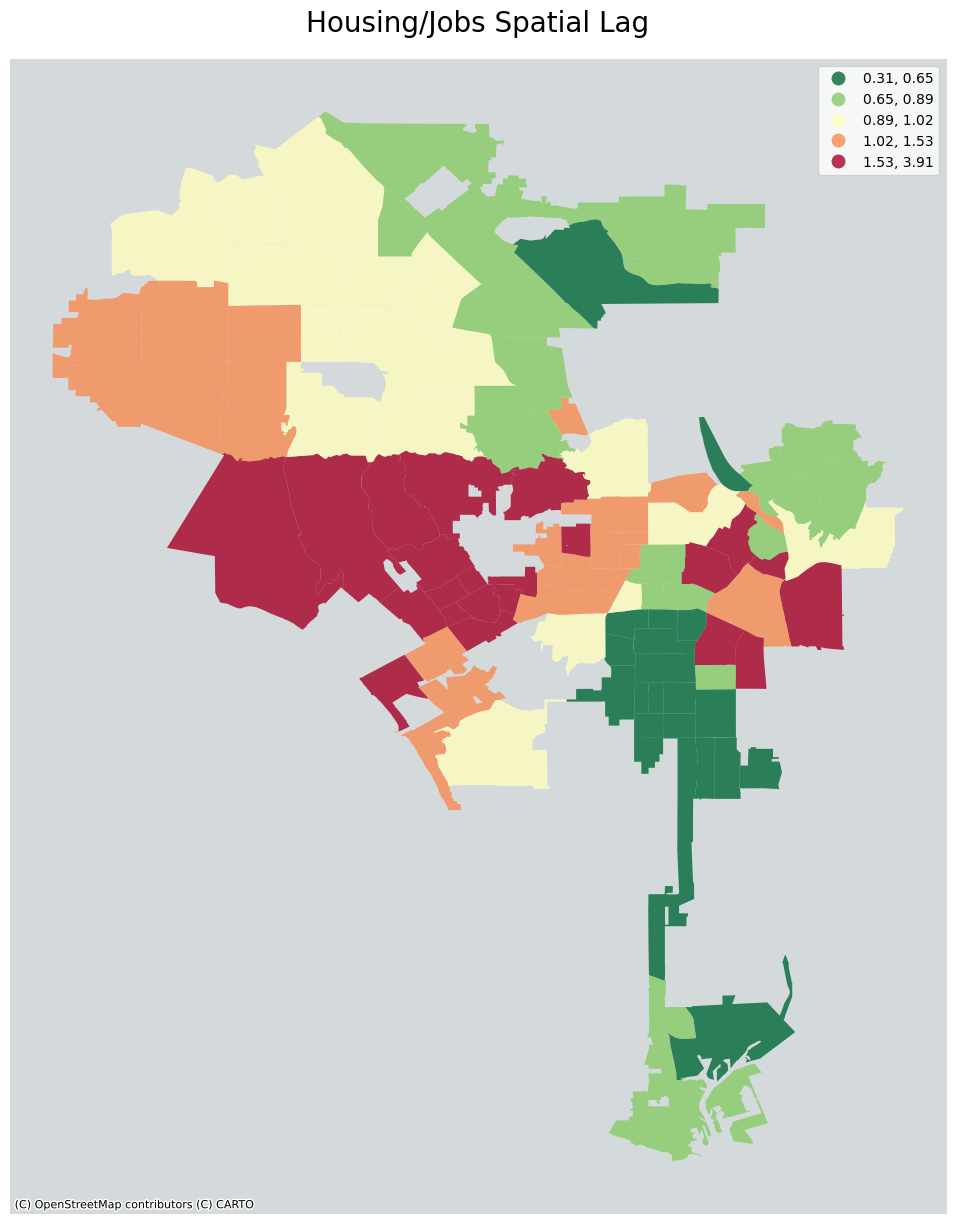

In [12]:
# use subplots that make it easier to create multiple layered maps
fig, ax = plt.subplots(figsize=(15, 15))

# spatial lag choropleth
jhgdf.plot(ax=ax,
         figsize=(15,15),
         column='Number_jobs_div_Housing_Lag',
         legend=True,
         alpha=0.8,
         cmap='RdYlGn_r',
         scheme='quantiles')

ax.axis('off')
ax.set_title('Housing/Jobs Spatial Lag',fontsize=20,pad=20)

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)